In [21]:
from expectation.seqtest.sequential_e_testing import SequentialTest
from expectation.utils.helper_functions import plot_sequential_test

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
# Compare two conversion rates
def simulate_conversions(rate, size):
    return np.random.binomial(1, rate, size)


In [27]:
# Simulation parameters
control_rate = 0.10    # 10% baseline conversion
treatment_rate = 0.35  # 20% treatment conversion
batch_size = 100       # Users per batch
n_batches = 50        # Number of batches to simulate

# Test H0: p1 = p2 vs H1: p1 > p2
prop_test = SequentialTest(
    test_type="proportion",
    null_value=0.1,  # H0: p_treatment = p_control
    alternative="greater"  # H1: p_treatment > p_control
)


In [28]:
results = []
treatment_conversions = []
control_conversions = []

for batch in range(n_batches):
    # Simulate batch of users
    control = simulate_conversions(control_rate, batch_size)
    treatment = simulate_conversions(treatment_rate, batch_size)
    
    # Store conversion rates
    treatment_conversions.append(np.mean(treatment))
    control_conversions.append(np.mean(control))
    
    # Compare treatment vs control (1 if treatment wins, 0 if control wins)
    comparisons = (treatment > control).astype(int)
    
    # Update test
    result = prop_test.update(comparisons)
    
    results.append({
        'batch': batch + 1,
        'treatment_rate': np.mean(treatment),
        'control_rate': np.mean(control),
        'e_value': result.e_value,
        'cumulative_e_value': result.e_process.cumulative_value,
        'reject_null': result.reject_null,
        'p_value': result.p_value,
        'sample_size': result.sample_size
    })

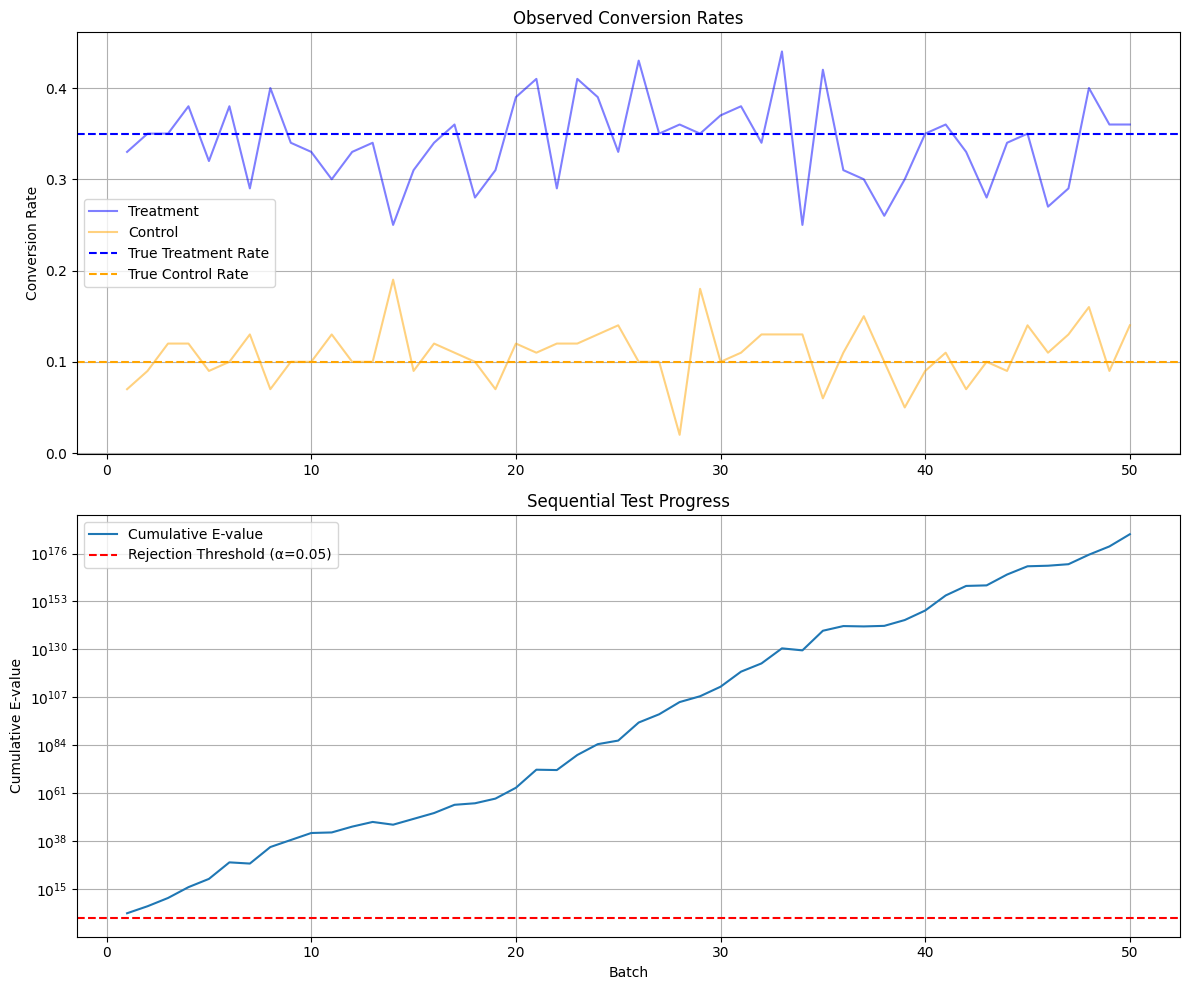


A/B Test Summary:
Total users: 10000
Average treatment conversion: 34.1%
Average control conversion: 10.9%
Observed lift: 213.6%

Significant difference detected at batch 1
Users required: 200


In [29]:
# Create visualization
history_df = pd.DataFrame(results)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Conversion Rates
ax1.plot(history_df['batch'], history_df['treatment_rate'], 
         label='Treatment', color='blue', alpha=0.5)
ax1.plot(history_df['batch'], history_df['control_rate'], 
         label='Control', color='orange', alpha=0.5)
ax1.axhline(y=treatment_rate, color='blue', linestyle='--', 
            label='True Treatment Rate')
ax1.axhline(y=control_rate, color='orange', linestyle='--', 
            label='True Control Rate')
ax1.set_title('Observed Conversion Rates')
ax1.set_ylabel('Conversion Rate')
ax1.legend()
ax1.grid(True)

# Plot 2: Sequential Test Results
ax2.plot(history_df['batch'], history_df['cumulative_e_value'], 
         label='Cumulative E-value')
ax2.axhline(y=20, color='r', linestyle='--', 
            label='Rejection Threshold (α=0.05)')
ax2.set_title('Sequential Test Progress')
ax2.set_ylabel('Cumulative E-value')
ax2.set_xlabel('Batch')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nA/B Test Summary:")
print(f"Total users: {history_df['sample_size'].iloc[-1] * 2}")  # *2 for both groups
print(f"Average treatment conversion: {np.mean(treatment_conversions):.1%}")
print(f"Average control conversion: {np.mean(control_conversions):.1%}")
print(f"Observed lift: {(np.mean(treatment_conversions)/np.mean(control_conversions) - 1):.1%}")

if any(history_df['reject_null']):
    first_sig = history_df[history_df['reject_null']].iloc[0]
    print(f"\nSignificant difference detected at batch {first_sig['batch']}")
    print(f"Users required: {first_sig['sample_size'] * 2}")
else:
    print("\nNo significant difference detected")

(<Figure size 1500x1000 with 3 Axes>,
 (<Axes: title={'center': 'Individual E-values'}, xlabel='Step', ylabel='E-value'>,
  <Axes: title={'center': 'Cumulative E-values (E-Process)'}, xlabel='Step', ylabel='Cumulative E-value'>,
  <Axes: title={'center': 'Raw Observations'}, xlabel='Step', ylabel='Value'>))

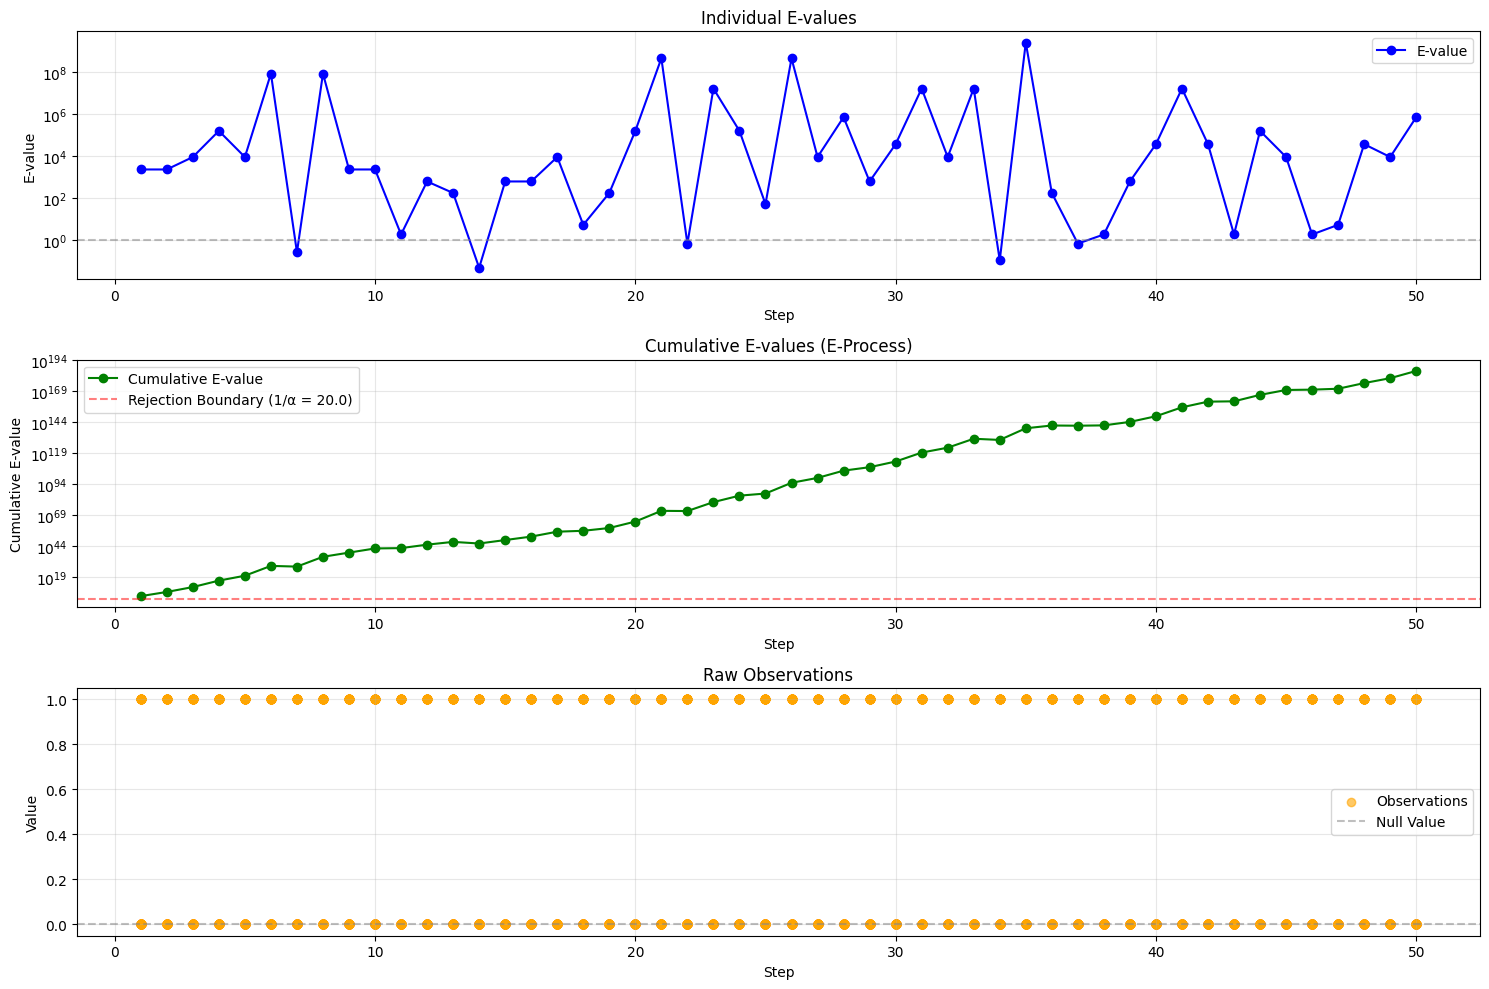

In [30]:
plot_sequential_test(prop_test.get_history_df(), log=True)